# ICORES 2020

In [1]:
import csv
import json
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

from lime.lime_text import LimeTextExplainer

from ortools.graph import pywrapgraph

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from collections import Counter

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/nkanak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nkanak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Data has been retrieved from the publicly accessible Jira instance of the open source projects of Apache Foundation.
# Check this URL: https://issues.apache.org/jira .
with open('data/hadoop_issues.json') as f:
    issues = json.load(f)
issues = issues['issues']

In [3]:
extra_stopwords = ["a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would"]

In [4]:
# Keep only the issues with assignee (HADOOP project).
issues = [issue for issue in issues if issue['fields'].get('assignee') is not None]

In [5]:
len(issues)

677

In [6]:
# TODO: Modify me!
NUMBER_OF_DEVELOPERS_INCLUDED = 4
most_common = Counter([issue['fields']['assignee']['key'] for issue in issues]).most_common(NUMBER_OF_DEVELOPERS_INCLUDED)
most_common

[('stevel@apache.org', 78),
 ('gabor.bota', 38),
 ('danielzhou', 34),
 ('ajisakaa', 24)]

In [7]:
included_developers = [developer_name for developer_name, _ in most_common]

In [8]:
# Keep only the issues of the 4 most important employees, i.e. employees with the highest number of assigned issues (statistical significance).
issues = [issue for issue in issues if issue['fields']['assignee']['key'] in included_developers]

In [9]:
included_developers

['stevel@apache.org', 'gabor.bota', 'danielzhou', 'ajisakaa']

In [10]:
len(issues)

174

In [11]:
unique_assignees_to_number_mapping = {assignee: key for key, assignee in enumerate(list(set(issue['fields']['assignee']['key'] for issue in issues)))}
unique_person_names = sorted([key for key in unique_assignees_to_number_mapping], key=lambda name: unique_assignees_to_number_mapping[name])
print(unique_assignees_to_number_mapping)

{'ajisakaa': 0, 'gabor.bota': 1, 'stevel@apache.org': 2, 'danielzhou': 3}


In [12]:
columns = {
    'class': [issue['fields']['assignee']['key'] for issue in issues],
    'text': [(issue['fields']['description'] if issue['fields']['description'] is not None else '') + ' ' + issue['fields']['summary'] for issue in issues],
}

In [13]:
# Compose and clean up text.
# The text of each issue is composed of two attrributes, namely description and summary (see above).
# Removal of english stop words is performed as well as lemmatization and stemming.
# Lemmatization (a Text Normalization technique) is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.
# Stemming is the process of reducing inflected (or sometimes derived) words to their base or root form.
# Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma.
# Stemming is different to Lemmatization in the approach it uses to produce root forms of words and the word produced.
# Also lemmatization and stemming techniques decrease the number of features of each row as far as machine learning is concerned.
for i in range(len(columns['text'])):
    columns['text'][i] = ' '.join([stemmer.stem(wordnet_lemmatizer.lemmatize(word.lower(), pos='v')) for word in columns['text'][i].split() if word.lower() not in stopwords.words('english') + extra_stopwords])

In [14]:
issues_df = pd.DataFrame.from_dict(columns)

In [15]:
issues_df['class'].value_counts()

stevel@apache.org    78
gabor.bota           38
danielzhou           34
ajisakaa             24
Name: class, dtype: int64

Text(0, 0.5, 'number of issues')

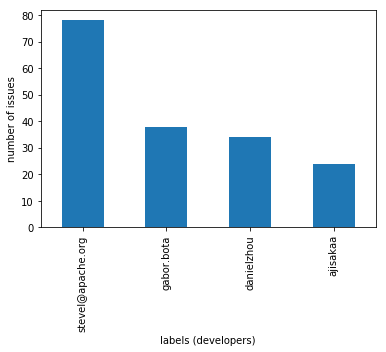

In [16]:
ax = issues_df['class'].value_counts().plot(kind='bar')
ax.set_xlabel('labels (developers)')
ax.set_ylabel('number of issues')

## Example

In [17]:
issues_df['label'] = issues_df['class'].map(unique_assignees_to_number_mapping)

In [18]:
X = issues_df['text']
y = issues_df['label']

# Tokenization, tag/feature generation and removal of frequently occured tags/words.
cv = CountVectorizer(stop_words='english', max_df=0.6)
X_transformed = cv.fit_transform(X)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_transformed, y, range(0, len(issues_df)), test_size=0.33, random_state=42)
print('Train size %s' % X_train.shape[0])
print('Test size %s' % X_test.shape[0])
print('Number of features %s' % X_test.shape[1])

Train size 116
Test size 58
Number of features 2403


In [19]:
# Naive Bayes classifier for multinomial models.
# The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).
# The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
naive_clf = MultinomialNB()
naive_clf.fit(X_train,y_train)
naive_clf.score(X_test,y_test)

0.8275862068965517

In [20]:
len(cv.vocabulary_)

2403

In [21]:
len(cv.get_feature_names())

2403

In [22]:
len(cv.stop_words_)

0

In [23]:
arr = X_transformed.toarray()

In [24]:
fieldnames = ['assignee', 'word', 'frequency']
with open('word_frequencies_per_assignee_old.csv', 'w') as f:
    csv_writer = csv.DictWriter(f, fieldnames=fieldnames)
    csv_writer.writeheader()
    for name in unique_person_names:
        x = issues_df[issues_df['class'] == name].index.values.tolist()
        for i in range(arr.shape[1]):
            if arr[x, i].sum() > 0:
                csv_writer.writerow({
                    'assignee': name,
                    'word': cv.get_feature_names()[i],
                    'frequency': arr[x, i].sum(),
                })
                #print((name, cv.get_feature_names()[i], arr[x, i].sum()))